In [1]:
import numpy as numpy
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
from torchvision import models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix  ,ConfusionMatrixDisplay




# Mount Drive to Extract Vegetable Images' File

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Device Configuration

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #resize images
    transforms.ToTensor(),   # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root = '/content/drive/MyDrive/Vegetable Images/train', transform=transform)
validation_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Vegetable Images/validation", transform=transform)
test_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Vegetable Images/test", transform=transform)

#Creating a Data Loader
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)





In [5]:
dataset = train_loader.dataset

if hasattr(dataset, 'classes'):
    # Print the class labels
    print(dataset.classes)
else:
    print("The dataset does not have a 'classes' attribute")

['Broccoli', 'Cabbage', 'Cauliflower']


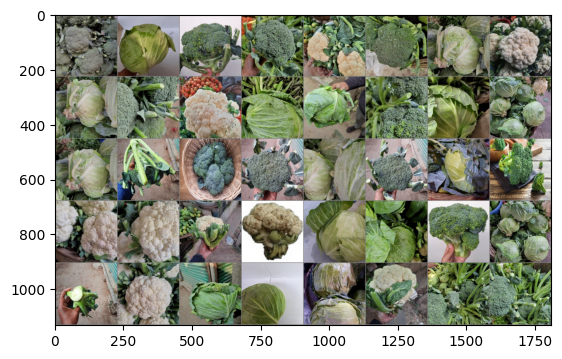

Broccoli Cabbage Broccoli Broccoli Cauliflower Broccoli Cabbage Cauliflower Cabbage Broccoli Cauliflower Cabbage Cabbage Broccoli Cabbage Cabbage Cabbage Broccoli Broccoli Broccoli Cabbage Broccoli Cabbage Broccoli Cauliflower Cauliflower Cauliflower Cauliflower Cabbage Cabbage Broccoli Cabbage Broccoli Cauliflower Cabbage Cabbage Cabbage Cauliflower Broccoli Broccoli


In [6]:
def imageshow(image):
    image = image / 2 + 0.5
    numpy_image = image.numpy()
    plt.imshow(np.transpose(numpy_image, (1, 2, 0)))
    plt.show()

data_iteration = iter(train_loader)
images, labels = next(data_iteration)

imageshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{train_dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(validation_dataset)}')
print(f'Number of test images: {len(test_dataset)}')

Number of training images: 3000
Number of validation images: 600
Number of test images: 600


# Train the Datasets

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models;
# from torchvision.models.vgg import VGG16_Weights;

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        vgg = models.vgg16(pretrained = True);

        for param in vgg.parameters():
            param.requires_grad = False

        self.vgg = vgg;

        self.output = nn.Linear(in_features = 1000, out_features = 3)

    def forward(self, x):
        x = self.vgg(x);
        x = self.output(x)
        x = F.softmax(x, dim=1)
        return x

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

In [9]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [23]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(20):  # loop over the dataset multiple times
    net.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(running_acc / len(train_loader))

    net.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_losses.append(val_loss / len(validation_loader))
    val_accs.append(val_acc / len(validation_loader))


    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}')

Epoch 1, Train Loss: 0.60, Train Acc: 0.95, Val Loss: 0.56, Val Acc: 1.00
Epoch 2, Train Loss: 0.56, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 3, Train Loss: 0.56, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 4, Train Loss: 0.55, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 5, Train Loss: 0.56, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 6, Train Loss: 0.56, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 7, Train Loss: 0.55, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 8, Train Loss: 0.56, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 9, Train Loss: 0.55, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 10, Train Loss: 0.55, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 11, Train Loss: 0.55, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 12, Train Loss: 0.55, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 13, Train Loss: 0.55, Train Acc: 1.00, Val Loss: 0.55, Val Acc: 1.00
Epoch 14, Train Loss: 0.55, Train 

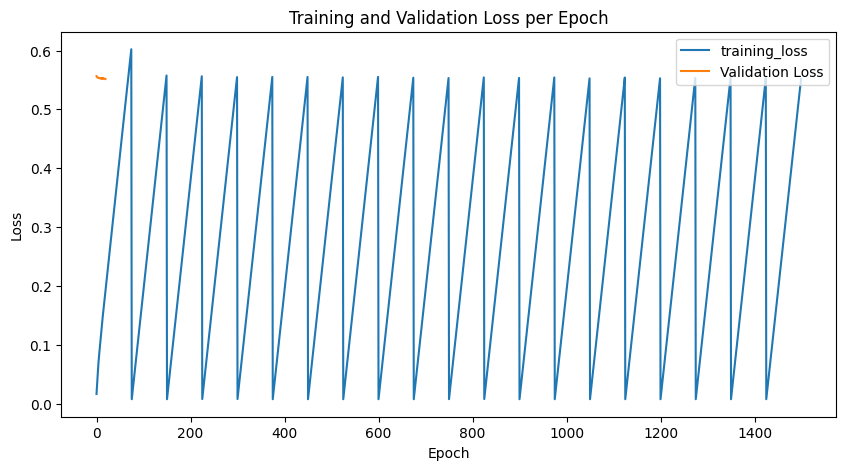

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label = 'training_loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
def calculate_confusion_matrix(label_actual, label_predict):
  f1 = f1_score(label_actual, label_predict, average = 'weighted')
  cf = confusion_matrix(label_actual, label_predict)
  return f1, cf

f1, cm = calculate_confusion_matrix(all_labels, all_preds)
print(f'Validation F1 Score: {f1:.2f}')

Validation F1 Score: 1.00


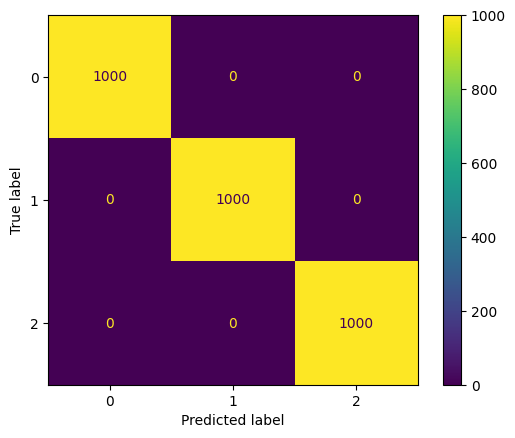

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [36]:
classes = ('broccoli', 'cabbage', 'cauliflower')
class_to_index = {class_name: i for i, class_name, in enumerate(classes)}

def class_name_encoded(classes,class_to_index):
  for i in enumerate (classes):
    print("index: ", i)
    num_classes = len(class_to_index)
    one_hot_matrix = np.zeros((len(classes), num_classes))
    for i, class_name in enumerate(classes):
      index = class_to_index.get(class_name)
      if index is None:
        raise ValueError(f"class name '{class_name}' not found !")
      one_hot_matrix[i, index] = 1
    return one_hot_matrix

one_hot_encoded_result = class_name_encoded(classes,class_to_index)
print(one_hot_encoded_result)

index:  (0, 'broccoli')
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [37]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=["0", "1", "2"])
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
from PIL import Image

vgg16 = models.vgg16(pretrained=True)
model = vgg16

# Freeze the convolutional base to prevent updating weights during training
for param in vgg16.features.parameters():
    param.requires_grad = False

# Load the weights
state_dict = torch.load('/content/drive/MyDrive/vgg16_transfer_learning.pth')

# Switch to evaluation mode
model.eval()

# Now you can use model to perform inference
# Load and prepare the image
image_path = '/content/drive/MyDrive/1002.jpg'
input_image = Image.open(image_path)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply the transforms to the image
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Convert output logits to predicted class (index) and probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

if probabilities.numel() == 0 :
   print("Error: Probabilities tensor is empty.")
else:
    max_value, predicted_class = torch.max(probabilities, 0)
    classes = ('broccoli', 'cabbage', 'cauliflower')

max_value, predicted_class = torch.max(probabilities, 0)
classes = ('broccoli', 'cabbage', 'cauliflower')

print("Predicted_Classes: ", predicted_class.item())
print("Class Length: ", len(classes))

# Ensure predicted_class is within the range of classes
if predicted_class.item() < len(classes):
    class_name = classes[predicted_class.item()]
    print(f'Predicted label: {class_name}, confidence: {max_value.item() *100:.2f}%')
else:
    print("Error: Predicted class index out of range.")


# Print the result
class_name = classes[predicted_class.item()]
print(f"Predicted label name: {class_name}")
print(f'Predicted label: {class_name}, confidence: {max_value.item() *100:.2f}%')

# Show the input image
plt.imshow(input_image)
plt.title(f'Predicted label: {class_name}, confidence: {max_value.item() * 100:.2f}%')
plt.show()